This notebook is for initial analysis of two-layer shallow water model runs for different wind stress magnitudes. For details on wind stress profile and topography, refer to notebook used for createing input files .

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dask
import dask.distributed
from xgcm import Grid
%matplotlib inline

from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34122 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 406.01 GB


In [2]:
# read ocean.stats files for all runs
tau = ['Tau_001', 'Tau_003', 'Tau_005', 'Tau_01', 'Tau_03', 'Tau_05', 'Tau_1']
ppdir = "/work/Hemant.Khatri/MOM6_idealised/SWM_Two_Layer/Barotropic_Baroclinic/"

dataset_FW = []
dataset_VW = []

for i in range(0, len(tau)):
    d = xr.open_dataset(ppdir+"2L_Fix_Width/"+tau[i]+"/ocean.stats.nc") 
    dataset_FW.append(d)
    d = xr.open_dataset(ppdir+"2L_Var_Width/"+tau[i]+"/ocean.stats.nc") 
    dataset_VW.append(d)
    
ds_FW = xr.concat(dataset_FW, dim='tau')
ds_VW = xr.concat(dataset_VW, dim='tau')

In [3]:
ds_FW

<xarray.Dataset>
Dimensions:        (Interface: 3, Layer: 2, Time: 731, tau: 7)
Coordinates:
  * Interface      (Interface) float64 1.027e+03 1.028e+03 1.028e+03
  * Time           (Time) timedelta64[ns] 0 days 10 days ... 7290 days 7300 days
  * Layer          (Layer) float64 1.027e+03 1.028e+03
Dimensions without coordinates: tau
Data variables:
    Ntrunc         (tau, Time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    En             (tau, Time) float64 0.0 2.251e+12 ... 7.697e+17 7.66e+17
    APE            (tau, Time, Interface) float64 0.0 0.0 0.0 ... 5.797e+17 0.0
    KE             (tau, Time, Layer) float64 0.0 0.0 ... 1.005e+17 8.522e+16
    H0             (tau, Time, Interface) float64 0.0 1e+03 ... 1e+03 4e+03
    Mass_lay       (tau, Time, Layer) float64 5.262e+18 1.521e+19 ... 1.521e+19
    Mass           (tau, Time) float64 2.047e+19 2.047e+19 ... 2.047e+19
    Mass_chg       (tau, Time) float64 0.0 -82.96 23.48 ... 46.57 -19.21 21.05
    Mass_anom      (tau, Time

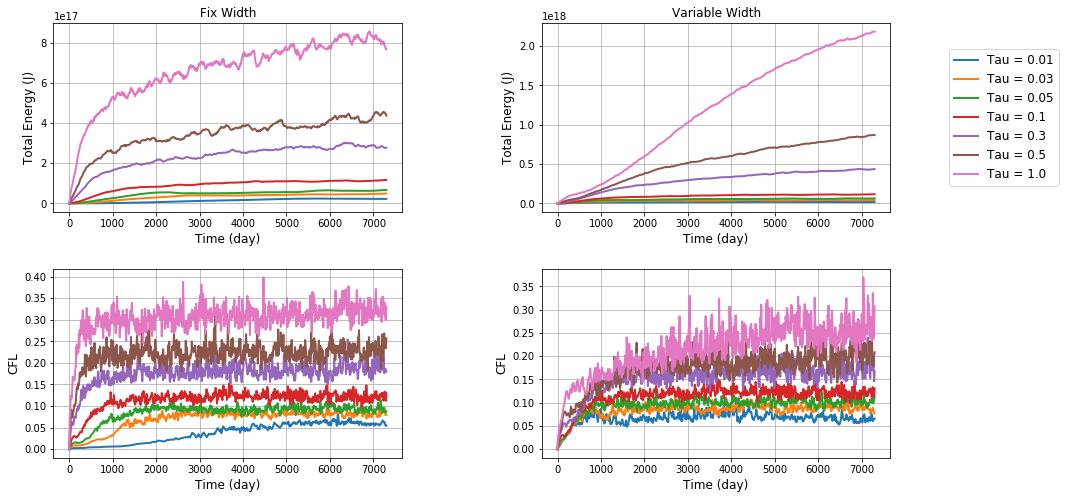

In [4]:
# Plot total energy, layerwise KE, CFL 
leg = ['0.01', '0.03', '0.05', '0.1', '0.3', '0.5', '1.0']

grid_plot = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
fig = plt.figure(figsize=[15,8])

ax = fig.add_subplot(grid_plot[0, 0])
ax.plot(ds_FW['Time']/(24*3600*1e9), ds_FW['En'].transpose(), lw=2)
ax.set_ylabel('Total Energy (J)',fontsize=12)
ax.set_xlabel('Time (day)', fontsize=12)
ax.grid()
#ax.set_yscale('log')
ax.set_title('Fix Width', fontsize=12)

ax = fig.add_subplot(grid_plot[0, 1])
ax.plot(ds_VW['Time']/(24*3600*1e9), ds_VW['En'].transpose(), lw=2)
ax.set_ylabel('Total Energy (J)',fontsize=12)
ax.set_xlabel('Time (day)', fontsize=12)
ax.grid()
#ax.set_yscale('log')
ax.set_title('Variable Width', fontsize=12)
ax.legend([ 'Tau = ' + str(lag) for lag in leg], loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize=12)

ax = fig.add_subplot(grid_plot[1, 0])
ax.plot(ds_FW['Time']/(24*3600*1e9), ds_FW['max_CFL_lin'].transpose(), lw=2)
ax.set_ylabel('CFL',fontsize=12)
ax.set_xlabel('Time (day)', fontsize=12)
ax.grid()

ax = fig.add_subplot(grid_plot[1, 1])
ax.plot(ds_VW['Time']/(24*3600*1e9), ds_VW['max_CFL_lin'].transpose(), lw=2)
ax.set_ylabel('CFL',fontsize=12)
ax.set_xlabel('Time (day)', fontsize=12)
ax.grid()

In [4]:
# read prog.nc files for all runs
tau = ['Tau_001', 'Tau_003', 'Tau_005', 'Tau_01', 'Tau_03', 'Tau_05', 'Tau_1']
ppdir = "/work/Hemant.Khatri/MOM6_idealised/SWM_Two_Layer/Barotropic_Baroclinic/"

dataset_FW = []
dataset_VW = []

for i in range(0, len(tau)):
    d = xr.open_dataset(ppdir+"2L_Fix_Width/"+tau[i]+"/prog.nc", chunks={'Time': 10}) # specifying chunks is required
    dataset_FW.append(d)
    d = xr.open_dataset(ppdir+"2L_Var_Width/"+tau[i]+"/prog.nc", chunks={'Time': 10}) # for parallel computations
    dataset_VW.append(d)
    
ds_FW1 = xr.concat(dataset_FW, dim='tau')
ds_VW1 = xr.concat(dataset_VW, dim='tau')

In [5]:
ds_FW1

<xarray.Dataset>
Dimensions:  (Time: 121, tau: 7, xh: 400, xq: 400, yh: 800, yq: 800, zi: 3, zl: 2)
Coordinates:
  * zl       (zl) float64 1.027e+03 1.028e+03
  * yq       (yq) float64 -1.596e+03 -1.592e+03 -1.588e+03 ... 1.596e+03 1.6e+03
  * xh       (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * xq       (xq) float64 4.0 8.0 12.0 16.0 ... 1.592e+03 1.596e+03 1.6e+03
  * Time     (Time) object 0001-03-02 00:00:00 ... 0020-11-17 00:00:00
  * yh       (yh) float64 -1.598e+03 -1.594e+03 ... 1.594e+03 1.598e+03
  * zi       (zi) float64 1.027e+03 1.028e+03 1.028e+03
Dimensions without coordinates: tau
Data variables:
    u        (tau, Time, zl, yh, xq) float32 dask.array<chunksize=(1, 10, 2, 800, 400), meta=np.ndarray>
    v        (tau, Time, zl, yq, xh) float32 dask.array<chunksize=(1, 10, 2, 800, 400), meta=np.ndarray>
    h        (tau, Time, zl, yh, xh) float32 dask.array<chunksize=(1, 10, 2, 800, 400), meta=np.ndarray>
    e        (tau, Time, zi, yh, xh) floa

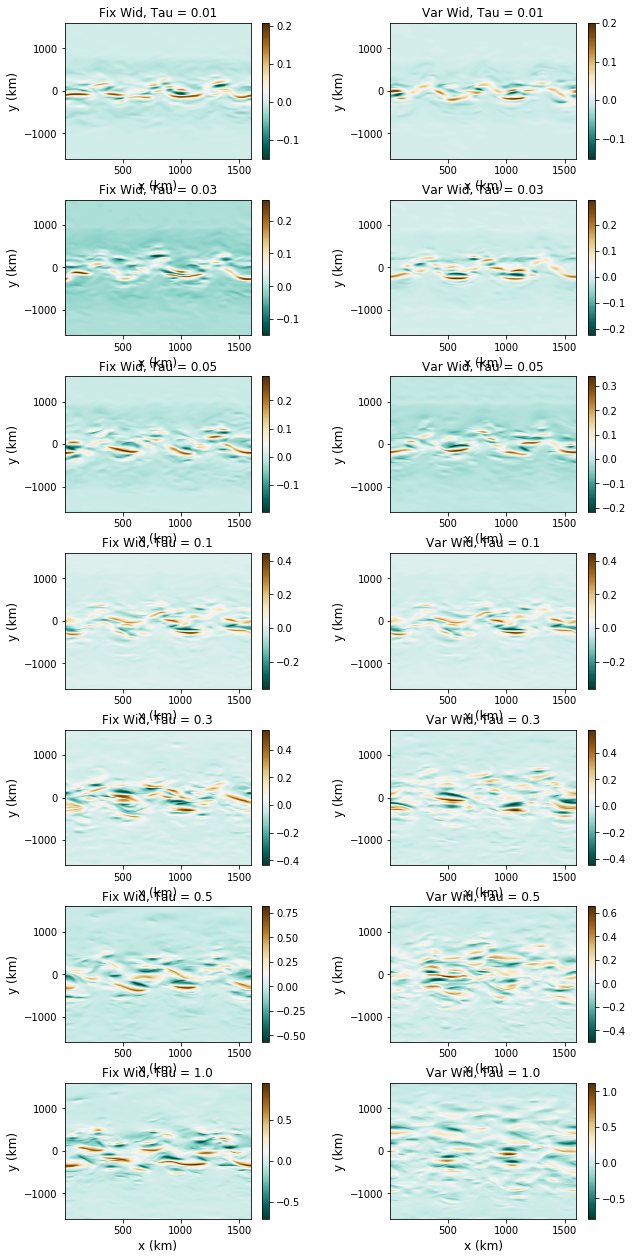

In [9]:
# Plot u snapshots
leg = ['0.01', '0.03', '0.05', '0.1', '0.3', '0.5', '1.0']

idx = 120

grid_plot = plt.GridSpec(7, 2, wspace=0.4, hspace=0.3)
fig = plt.figure(figsize=[10,22])

for i in range(0, ds_FW1.tau.shape[0]):
    
    ax = fig.add_subplot(grid_plot[i, 0])
    img = ax.pcolor(ds_FW1['xq'], ds_FW1['yh'], ds_FW1['u'].isel(Time=idx, zl=0, tau=i), cmap='BrBG_r')
    ax.set_ylabel('y (km)',fontsize=12)
    ax.set_xlabel('x (km)', fontsize=12)
    ax.set_title('Fix Wid, Tau = ' + leg[i], fontsize=12)
    #ax.colorbar()
    fig.colorbar(img, ax=ax)
    
    ax = fig.add_subplot(grid_plot[i, 1])
    img = ax.pcolor(ds_VW1['xq'], ds_VW1['yh'], ds_VW1['u'].isel(Time=idx, zl=0, tau=i), cmap='BrBG_r')
    ax.set_ylabel('y (km)',fontsize=12)
    ax.set_xlabel('x (km)', fontsize=12)
    ax.set_title('Var Wid, Tau = ' + leg[i], fontsize=12)
    fig.colorbar(img, ax=ax)
    #ax.colorbar()

In [24]:
# Time evolution of zonal transport

grid_FW = Grid(ds_FW1, coords={'X': {'center': 'xh', 'right': 'xq'},
                            'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X']);
grid_VW = Grid(ds_VW1, coords={'X': {'center': 'xh', 'right': 'xq'},
                            'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X']);
dy = 4000.

umo_FW = (ds_FW1['u'] * grid_FW.interp(ds_FW1['h'], 'X', boundary='fill') * dy).mean('xq').sum('yh').compute()
umo_VW = (ds_VW1['u'] * grid_VW.interp(ds_VW1['h'], 'X', boundary='fill') * dy).mean('xq').sum('yh').compute()

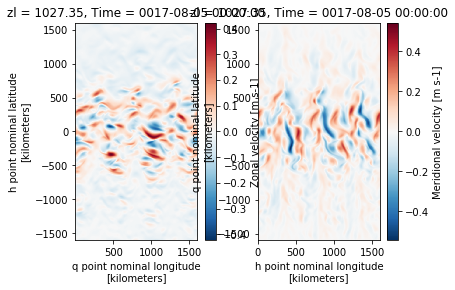

In [23]:
#(ds_FW1['u']*grid.interp(ds_FW1['h'], 'X', boundary='fill')).isel(Time = 100, zl=0, tau=3).plot()
#(ds_FW1['u'].isel(xq=100)*0.5*(ds_FW1['h'].isel(xh=100) + ds_FW1['h'].isel(xh=101))).isel(Time = 50, zl=0, tau=6).plot()

plt.subplot(1,2,1)
(ds_VW1['u']).isel(Time = 100, zl=0, tau=4).plot()

plt.subplot(1,2,2)
(ds_VW1['v']).isel(Time = 100, zl=0, tau=4).plot()

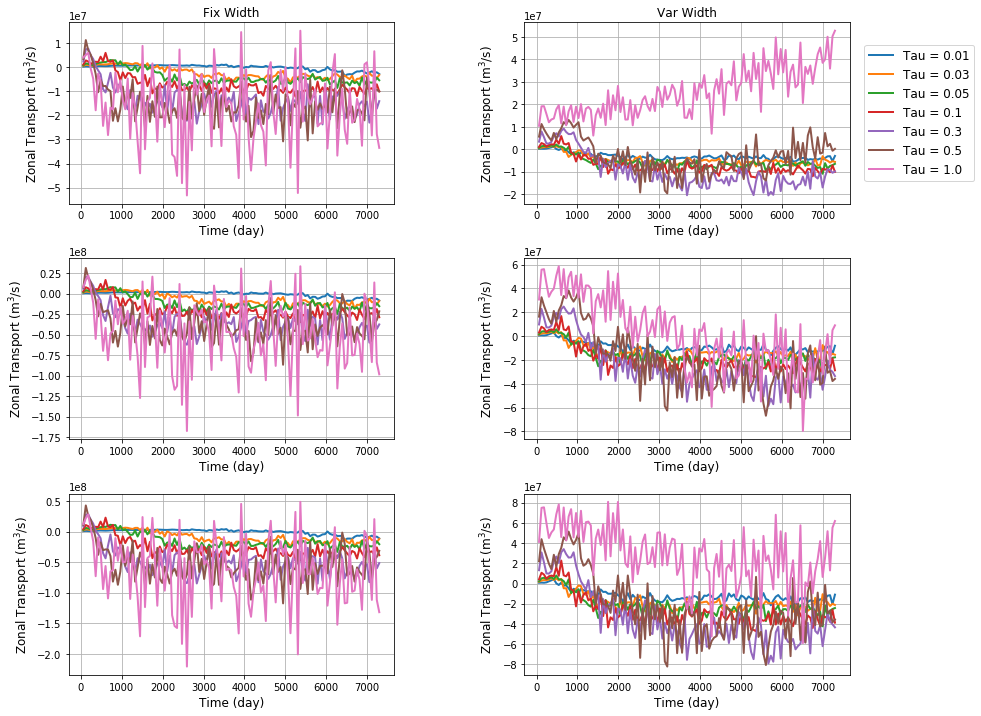

In [26]:
# Plot u snapshots
leg = ['0.01', '0.03', '0.05', '0.1', '0.3', '0.5', '1.0']

grid_plot = plt.GridSpec(3, 2, wspace=0.4, hspace=0.3)
fig = plt.figure(figsize=[14,12])
tim = np.linspace(60., 7300., len(ds_FW1['Time']), endpoint=True)

for i in range(0,3):
    
    if(i==0):
        tmp = umo_FW.isel(zl=0)
    elif(i==1):
        tmp = umo_FW.isel(zl=1)
    else:
        tmp = umo_FW.sum('zl')
    
    ax = fig.add_subplot(grid_plot[i, 0])
    ax.plot(tim, tmp.transpose(), lw=2)
    ax.set_ylabel('Zonal Transport (m$^3$/s)',fontsize=12)
    ax.set_xlabel('Time (day)', fontsize=12)
    ax.grid()
    #ax.set_yscale('log')
    if(i==0):
        ax.set_title('Fix Width', fontsize=12)
    
    if(i==0):
        tmp = umo_VW.isel(zl=0)
    elif(i==1):
        tmp = umo_VW.isel(zl=1)
    else:
        tmp = umo_VW.sum('zl')
        
    ax = fig.add_subplot(grid_plot[i, 1])
    ax.plot(tim, tmp.transpose(), lw=2)
    ax.set_ylabel('Zonal Transport (m$^3$/s)',fontsize=12)
    ax.set_xlabel('Time (day)', fontsize=12)
    ax.grid()
    #ax.set_yscale('log')
    if(i==0):
        ax.set_title('Var Width', fontsize=12)
        ax.legend([ 'Tau = ' + str(lag) for lag in leg], loc='center right', bbox_to_anchor=(1.4, 0.5), fontsize=12)

In [27]:
ds_FW.close()
ds_VW.close()
ds_FW1.close()
ds_VW1.close()
client.close()
cluster.close()